# Ejercicio Ridge, Lasso y ElasticNet
Para este ejercicio vas a trabajar con datos de ventas de una empresa que fabrica muebles en España. Esta empresa es una Pyme que demanda conocer de antemano qué ingresos va a tener cada mes, ya que necesita pedir un anticipio a su entidad financiera de cara a poder abastecerse de materia prima al comenzar el mes. Como desconoce cuánto tiene que pedir, tira al alza y acaba pagando muchos intereses. El objetivo es reducir estos gastos.

En las bases de datos de la empresa constan todos los gastos en publicidad y ventas, para cada uno de los meses desde su fundación (hace más de 15 años).

Dado que los presupuestos de marketing se cierran al principio de cada mes, la empresa necesita un modelo predictivo que le anticipe las ventas que conseguirá a final de mes en función de los gastos que realizará en marketing.

Para ello tendrás que utilizar tanto modelos de regresión normales, como regularizados.

1. Carga los datos y realiza un pequeño análisis exploratorio. Mira a ver cómo se relaciona las ventas con el resto de variables.
2. Crea varios modelos y modifica los hiperparámetros necesarios para mejorar el performance del modelo.
3. Interpreta los resultados. Traduce a una fórmula tu mejor modelo (escribir la fórmula simplemente). ¿Cuánto cambian las ventas si aumentamos la inversión en radio un punto más? ¿Y si aumentamos la inversión en TV o periódicos?

## Import libraries 

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Exploratory Data Analysis 

In [54]:
DATAPATH = 'data/Advertising.csv'

data = pd.read_csv(DATAPATH)
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22100.0
1,44.5,39.3,45.1,10400.0
2,17.2,45.9,69.3,9300.0
3,151.5,41.3,58.5,18500.0
4,180.8,10.8,58.4,12900.0


Cantidad de datos:

In [55]:
data.shape

(200, 4)

Distribuciones y gráficos de dispersión de las variables

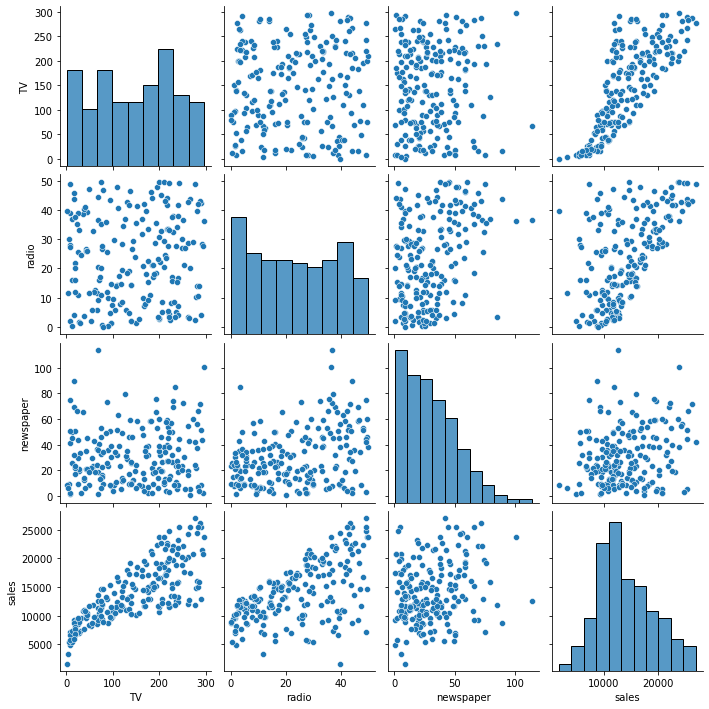

In [56]:
sns.pairplot(data)

- **TV**: Parece que la relación entre las ventas y la inversión en TV es no lineal. Podríamos intentar una aproximación polinómica. Aún así, podemos apreciar que tendremos una correlación positiva. Es decir, una mayor inversión en TV se traducirá en un incremento de las ventas.

- **Radio**: La relación podría considerarse lineal en apariencia, aunque se observa mucha dispersión en la región $y<x$. Esto podría interpretarse como que grandes inversiones en radio tienen un gran retorno en las ventas en algunos casos y en otros no. La cause puede deberse al decaimiento de la radio como medio de comunicacón en la actualidad con respecto a la época de fundación de la empresa.

- **Newspaper**: La relación que se tiene es prácticamente aleatoria y no se puede concluir una tendencia concreta.

Para contrastar estas hipótesis, representemos gráficamente la inversión en TV, Radio y Periódico.

<AxesSubplot:>

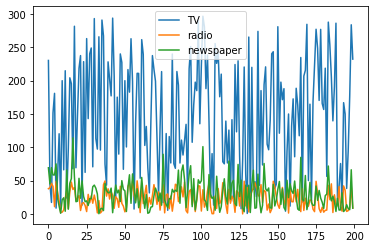

In [57]:
data[['TV', 'radio', 'newspaper']].plot()

In [58]:
di = data.index % 12 +1
# di2 = np.where(di == 0, 12, di)
# di2[0] = 0
di.unique()

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

In [59]:
data.index = pd.date_range('2000-07', periods=len(data), freq='M')

In [60]:
data.head()

,TV,radio,newspaper,sales
2000-07-31,230.1,37.8,69.2,22100.0
2000-08-31,44.5,39.3,45.1,10400.0
2000-09-30,17.2,45.9,69.3,9300.0
2000-10-31,151.5,41.3,58.5,18500.0
2000-11-30,180.8,10.8,58.4,12900.0


In [61]:
data.tail()

,TV,radio,newspaper,sales
2016-10-31,38.2,3.7,13.8,7600.0
2016-11-30,94.2,4.9,8.1,9700.0
2016-12-31,177.0,9.3,6.4,12800.0
2017-01-31,283.6,42.0,66.2,25500.0
2017-02-28,232.1,8.6,8.7,13400.0


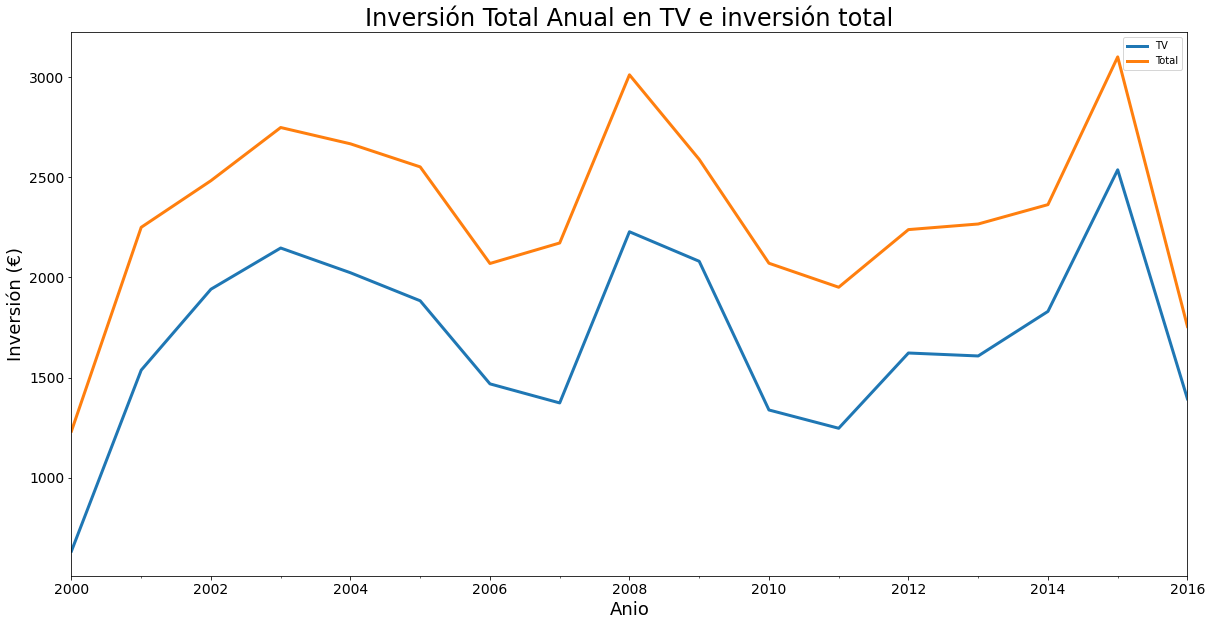

In [62]:
fig, ax = plt.subplots(1, figsize=(20, 10))
data.loc[data.index.year < 2017, ['TV']].resample('Y').sum().plot(linewidth=3, ax=ax)
data.loc[data.index.year < 2017, ['TV', 'radio', 'newspaper']].sum(axis=1).resample('Y').sum().plot(linewidth=3, ax=ax)
plt.legend(['TV', 'Total'])
plt.title("Inversión Total Anual en TV e inversión total", fontsize=24)
plt.xlabel("Anio", fontsize=18) # , 'radio', 'newspaper'
plt.ylabel("Inversión (€)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

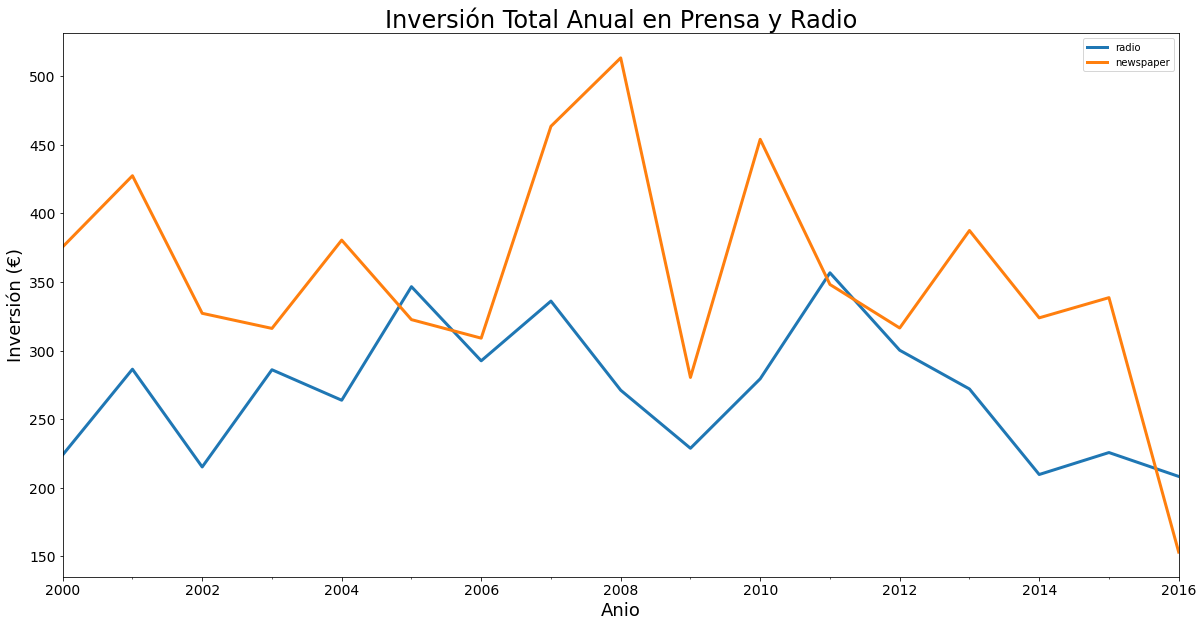

In [63]:
data.loc[data.index.year < 2017, ['radio', 'newspaper']].resample('Y').sum().plot(figsize=(20, 10), linewidth=3)
plt.title("Inversión Total Anual en Prensa y Radio", fontsize=24)
plt.xlabel("Anio", fontsize=18) # , 'radio', 'newspaper'
plt.ylabel("Inversión (€)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

La mayoría de la inversión se produce en TV por lo que una subida de la inversión total será debida a una subida en TV y viceversa. Es mejor trabajar con los porcentajes de inversion.

In [91]:
data_pc = data.loc[data.index.year < 2017, ['TV', 'radio', 'newspaper']].copy()
data_pc_yr = data_pc.resample('Y').sum()
total = data_pc_yr.sum(axis=1)
# data_pc = data_pc_yr / data_pc_yr.sum(axis=1) * 100
data_pc_yr.loc[:, :] = data_pc_yr.values / total.values.reshape(-1, 1) * 100
data_pc_yr


,TV,radio,newspaper
2000-12-31,51.351132,18.177392,30.471476
2001-12-31,68.288456,12.725495,18.986048
2002-12-31,78.165640,8.664492,13.169868
2003-12-31,78.099880,10.402648,11.497472
2004-12-31,75.852763,9.888297,14.258940
2005-12-31,73.790402,13.574927,12.634672
2006-12-31,70.940625,14.131117,14.928257
2007-12-31,63.206592,15.466765,21.326643
2008-12-31,73.969329,8.998871,17.031800
2009-12-31,80.340527,8.833636,10.825837


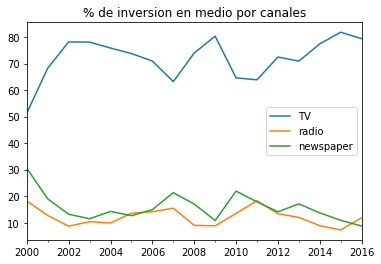

In [94]:
data_pc_yr.plot(title='% de inversion en medio por canales');

Correlaciones

<AxesSubplot:>

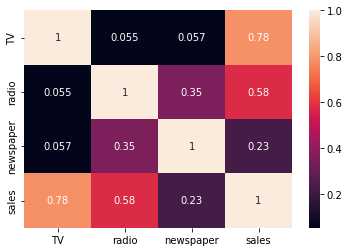

In [96]:
sns.heatmap(data.corr(), annot=True)

Puesto que la correlación entre algunas de las variables son significativas, quizá sería mejor hacer una regresión directamente con el total de inversión

<AxesSubplot:>

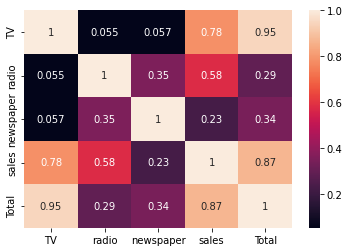

In [98]:
data_wt = data.copy()
data_wt['Total'] = data_wt.loc[:, ['TV', 'radio', 'newspaper']].sum(axis=1)
sns.heatmap(data_wt.corr(), annot=True)

<AxesSubplot:xlabel='Total', ylabel='sales'>

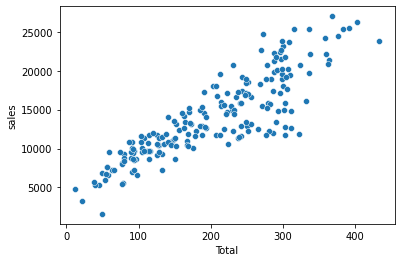

In [100]:
sns.scatterplot(data=data_wt, x='Total', y='sales')

# Modelos

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Obtenemos la X y la y
X = data.loc[:, ['TV', 'radio', 'newspaper']].copy()
y = data['sales'].copy()

# Separamos en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=False)

# Escalamos los valores
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## Linear Regression

In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lm = LinearRegression()
lm.fit(X_train_sc, y_train)

y_lm = lm.predict(X_test_sc)
y_lm_tr = lm.predict(X_train_sc)

mae_lin_tr = mean_absolute_error(y_train, y_lm_tr)
mae_lin = mean_absolute_error(y_test, y_lm)

r2_lin_tr = r2_score(y_train, y_lm_tr)
r2_lin = r2_score(y_test, y_lm)


print("TRAIN")
print(f"MAE: {mae_lin_tr:.2f}")
print(f"R^2: {r2_lin_tr:.2f}")
print("="*50, end="\n"*2)

print("TEST")
print(f"MAE: {mae_lin:.2f}")
print(f"R^2: {r2_lin:.2f}")
print("="*50, end="\n"*2)

TRAIN
MAE: 1257.66
R^2: 0.90

TEST
MAE: 1287.72
R^2: 0.90



## Ridge

In [109]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score

ls_alpha = [1e-15, 1e-10, 1e-5, 1, 5, 10, 15, 20]
ls_mae_tr = []
ls_mae_ts = []

for alpha in ls_alpha:
    lm_rd = Ridge(alpha=alpha)
    lm_rd.fit(X_train_sc, y_train)

    y_lm = lm_rd.predict(X_test_sc)
    y_lm_tr = lm_rd.predict(X_train_sc)

    mae_lin_tr = mean_absolute_error(y_train, y_lm_tr)
    mae_lin = mean_absolute_error(y_test, y_lm)

    r2_lin_tr = r2_score(y_train, y_lm_tr)
    r2_lin = r2_score(y_test, y_lm)


    print("TRAIN")
    print(f"MAE: {mae_lin_tr:.2f}")
    print(f"R^2: {r2_lin_tr:.2f}")
    print("="*50, end="\n"*2)

    print("TEST")
    print(f"MAE: {mae_lin:.2f}")
    print(f"R^2: {r2_lin:.2f}")
    print("="*50, end="\n"*2)

    ls_mae_ts.append(mae_lin)
    ls_mae_tr.append(mae_lin_tr)


TRAIN
MAE: 1257.66
R^2: 0.90

TEST
MAE: 1287.72
R^2: 0.90

TRAIN
MAE: 1257.66
R^2: 0.90

TEST
MAE: 1287.72
R^2: 0.90

TRAIN
MAE: 1257.66
R^2: 0.90

TEST
MAE: 1287.72
R^2: 0.90

TRAIN
MAE: 1258.06
R^2: 0.90

TEST
MAE: 1285.74
R^2: 0.90

TRAIN
MAE: 1262.46
R^2: 0.90

TEST
MAE: 1280.28
R^2: 0.90

TRAIN
MAE: 1271.84
R^2: 0.89

TEST
MAE: 1279.56
R^2: 0.90

TRAIN
MAE: 1287.13
R^2: 0.89

TEST
MAE: 1279.22
R^2: 0.89

TRAIN
MAE: 1303.68
R^2: 0.89

TEST
MAE: 1288.20
R^2: 0.89



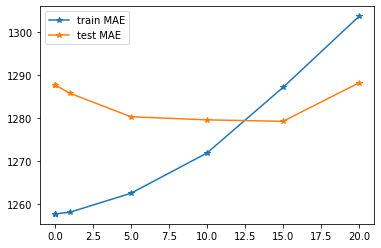

In [116]:
plt.plot(ls_alpha, ls_mae_tr, marker='*', label="train MAE")
plt.plot(ls_alpha, ls_mae_ts, marker='*', label="test MAE")
plt.legend()

In [117]:
ls_alpha = np.linspace(10, 17.5, 20)
ls_mae_tr = []
ls_mae_ts = []

for alpha in ls_alpha:
    lm_rd = Ridge(alpha=alpha)
    lm_rd.fit(X_train_sc, y_train)

    y_lm = lm_rd.predict(X_test_sc)
    y_lm_tr = lm_rd.predict(X_train_sc)

    mae_lin_tr = mean_absolute_error(y_train, y_lm_tr)
    mae_lin = mean_absolute_error(y_test, y_lm)

    r2_lin_tr = r2_score(y_train, y_lm_tr)
    r2_lin = r2_score(y_test, y_lm)


    print("TRAIN")
    print(f"MAE: {mae_lin_tr:.2f}")
    print(f"R^2: {r2_lin_tr:.2f}")
    print("="*50, end="\n"*2)

    print("TEST")
    print(f"MAE: {mae_lin:.2f}")
    print(f"R^2: {r2_lin:.2f}")
    print("="*50, end="\n"*2)

    ls_mae_ts.append(mae_lin)
    ls_mae_tr.append(mae_lin_tr)


TRAIN
MAE: 1271.84
R^2: 0.89

TEST
MAE: 1279.56
R^2: 0.90

TRAIN
MAE: 1272.73
R^2: 0.89

TEST
MAE: 1279.54
R^2: 0.90

TRAIN
MAE: 1273.72
R^2: 0.89

TEST
MAE: 1279.52
R^2: 0.90

TRAIN
MAE: 1274.88
R^2: 0.89

TEST
MAE: 1279.50
R^2: 0.90

TRAIN
MAE: 1276.06
R^2: 0.89

TEST
MAE: 1279.48
R^2: 0.90

TRAIN
MAE: 1277.28
R^2: 0.89

TEST
MAE: 1279.45
R^2: 0.90

TRAIN
MAE: 1278.55
R^2: 0.89

TEST
MAE: 1279.43
R^2: 0.90

TRAIN
MAE: 1279.81
R^2: 0.89

TEST
MAE: 1279.40
R^2: 0.90

TRAIN
MAE: 1281.06
R^2: 0.89

TEST
MAE: 1279.37
R^2: 0.90

TRAIN
MAE: 1282.31
R^2: 0.89

TEST
MAE: 1279.34
R^2: 0.90

TRAIN
MAE: 1283.55
R^2: 0.89

TEST
MAE: 1279.31
R^2: 0.89

TRAIN
MAE: 1284.90
R^2: 0.89

TEST
MAE: 1279.28
R^2: 0.89

TRAIN
MAE: 1286.24
R^2: 0.89

TEST
MAE: 1279.24
R^2: 0.89

TRAIN
MAE: 1287.57
R^2: 0.89

TEST
MAE: 1279.21
R^2: 0.89

TRAIN
MAE: 1288.89
R^2: 0.89

TEST
MAE: 1279.17
R^2: 0.89

TRAIN
MAE: 1290.21
R^2: 0.89

TEST
MAE: 1279.13
R^2: 0.89

TRAIN
MAE: 1291.53
R^2: 0.89

TEST
MAE: 1279.09
R^2: 0.8

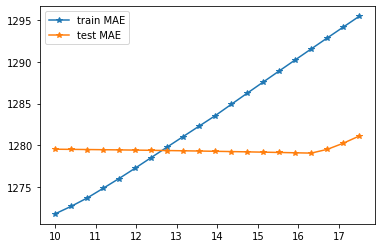

In [118]:
plt.plot(ls_alpha, ls_mae_tr, marker='*', label="train MAE")
plt.plot(ls_alpha, ls_mae_ts, marker='*', label="test MAE")
plt.legend()

Parece que $\alpha=10$ es la mejor opción